In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, auc, classification_report, roc_auc_score, roc_curve
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pprint
import pandas as pd
import xgboost as xgb

In [2]:
train_df = pd.read_csv('data.csv')
test_df = pd.read_parquet('data-val.parquet')

In [3]:
## Make sure that the dataset 

# Find common columns
common_columns = train_df.columns.intersection(test_df.columns)

# Drop uncommon columns
removed_columns = set(train_df.columns).symmetric_difference(test_df.columns)
train_df_filtered = train_df[common_columns]
test_df_filtered = test_df[common_columns]

# Print removed columns
print("Removed columns:", removed_columns)

Removed columns: {'SUM_NOT_TRANSFER_3m', 'SUM_AMT_TRANSFER_3m', 'Unnamed: 0.1'}


In [4]:
# Comparing number of columns
print("Train data:", train_df_filtered.shape[1])
print("Test data:", test_df_filtered.shape[1])

Train data: 57
Test data: 57


In [5]:
## Dropping irrelavant columns

# Train_data
train_df_filtered = train_df_filtered.drop(columns=['Age_x','CIF_CLSCUS', 'COB_DATE', 'DATE_TIME', 'BRN_OPN_CIF', 'MA_PHONG_GIAO_DICH_VCB', 'CIF_MASK', 'IS_TM', 'Unnamed: 0', 'SUM_CBALQ_LH_6m', 'SUM_CBALQ_LH_3m', 'AVG_GR_SUM_CBALQ_LH'])

# Test_data 
test_df_filtered = test_df_filtered.drop(columns=['Age_x','CIF_CLSCUS', 'COB_DATE', 'DATE_TIME', 'BRN_OPN_CIF', 'MA_PHONG_GIAO_DICH_VCB', 'CIF_MASK', 'IS_TM', 'Unnamed: 0', 'SUM_CBALQ_LH_6m', 'SUM_CBALQ_LH_3m', 'AVG_GR_SUM_CBALQ_LH'])

In [6]:
# Comparing number of columns
print("Train data:", train_df_filtered.shape[1])
print("Test data:", test_df_filtered.shape[1])
print('Selected columns:\n', test_df_filtered.columns)

Train data: 45
Test data: 45
Selected columns:
 Index(['CBALQ_3m', 'AVG_SL_SP_BOSUNG', 'NO_TREN_CO_6m',
       'LOAIHINHCOQUANDANGCONGTAC', 'SUM_CBALQ_LH', 'BHNT_flag',
       'MEDIAN_GR_SUM_AMT', 'TINHTRANGSOHUUNHA', 'TINHTRANGHONNHAN', 'Khu_vuc',
       'BHNT_after21', 'Sum_PPC', 'MEDIAN_GR_THGCO', 'BHSK_remain',
       'IS_BANCAS', 'AVG_GR_CBALQ', 'CBALQ_6m', 'AVG_CBALQ_6m', 'BHNT_remain',
       'AVG_GR_THGCO', 'IS_TM.1', 'Age_y', 'THGCO_3m', 'CNT_TGCCKH',
       'THGNO_6m', 'IS_TA', 'TONGTHUNHAPHANGTHANG', 'Snapshot', 'BHSK_flag',
       'THGCO_6m', 'MEDIAN_GR_CBALQ', 'AVG_CBALQ_TGCCKH', 'THGNO_3m',
       'TINHCHATCONGVIECHIENTAI', 'AVG_AMT_3M', 'NO_TREN_CO_3m',
       'AVG_CBALQ_3m', 'Prio_flag', 'SONGUOIPHUTHUOC', 'THOIGIANLAMVIECLVHT',
       'BHSK_after21', 'Payroll_Flag', 'AVG_GR_THGNO', 'CUS_GEN',
       'MEDIAN_GR_THGNO'],
      dtype='object')


In [7]:
# Only choosing the appropriate columns

cols_to_choose = ['Age_y', 'LOAIHINHCOQUANDANGCONGTAC','TINHTRANGSOHUUNHA', 'TINHTRANGHONNHAN', 'Khu_vuc','BHNT_after21' ,'BHSK_after21','BHSK_remain', 'SONGUOIPHUTHUOC','CUS_GEN','BHNT_remain','TONGTHUNHAPHANGTHANG','SUM_CBALQ_LH', 'IS_BANCAS']

train_df = train_df_filtered[cols_to_choose]
test_df = test_df_filtered[cols_to_choose]

train_df.head()

,Age_y,LOAIHINHCOQUANDANGCONGTAC,TINHTRANGSOHUUNHA,TINHTRANGHONNHAN,Khu_vuc,BHNT_after21,BHSK_after21,BHSK_remain,SONGUOIPHUTHUOC,CUS_GEN,BHNT_remain,TONGTHUNHAPHANGTHANG,SUM_CBALQ_LH,IS_BANCAS
0,22.0,NaN,NaN,NaN,Tp.HCM,NaN,NaN,NaN,NaN,F,NaN,NaN,100000000.0,1.0
1,29.0,NaN,NaN,NaN,HN,0.0,1.0,0.0,NaN,M,0.0,NaN,0.0,1.0
2,34.0,NaN,NaN,NaN,BTTB,NaN,NaN,NaN,NaN,M,NaN,NaN,0.0,1.0
3,58.0,NaN,NaN,NaN,HN,1.0,0.0,0.0,NaN,F,0.0,NaN,0.0,1.0
4,45.0,NaN,NaN,NaN,ĐNB,NaN,NaN,NaN,NaN,M,NaN,NaN,NaN,1.0


In [8]:
train_df = train_df.rename(columns={'Age_y': 'Age', 'SUM_CBALQ_LH': "So_du"})
test_df = test_df.rename(columns={'Age_y': 'Age', 'SUM_CBALQ_LH': "So_du"})


In [9]:
# Bin age

age_bin_edges = [0, 20, 25, 30, 35, 40, 45, 50, 55, 60, float('inf')]
labels = ['Duoi 20', '20 toi 24', '25 toi 29', '30 toi 34', '35 toi 39', '40 toi 44', '45 toi 49', '50 toi 54', '55 toi 59', 'Tren 60']

train_df['Age_group'] = pd.cut(train_df['Age'], bins=age_bin_edges, labels=labels, right=False)
train_df = train_df.drop(columns=['Age'])
test_df['Age_group'] = pd.cut(test_df['Age'], bins=age_bin_edges, labels=labels, right=False)
test_df = test_df.drop(columns=['Age'])

In [10]:
# BHNT and BHSK

bh_mapping = {0: 'No', 1: 'Yes'}

for col in ['BHNT_after21', 'BHNT_remain', 'BHSK_after21', 'BHSK_remain']:
    train_df[col] = train_df[col].replace(bh_mapping)
    train_df[col] = train_df[col].fillna("No Info")
    test_df[col] = test_df[col].replace(bh_mapping)
    test_df[col] = test_df[col].fillna("No Info")
    
    
    
test_df.head()
train_df.head()

,LOAIHINHCOQUANDANGCONGTAC,TINHTRANGSOHUUNHA,TINHTRANGHONNHAN,Khu_vuc,BHNT_after21,BHSK_after21,BHSK_remain,SONGUOIPHUTHUOC,CUS_GEN,BHNT_remain,TONGTHUNHAPHANGTHANG,So_du,IS_BANCAS,Age_group
0,NaN,NaN,NaN,Tp.HCM,No Info,No Info,No Info,NaN,F,No Info,NaN,100000000.0,1.0,20 toi 24
1,NaN,NaN,NaN,HN,No,Yes,No,NaN,M,No,NaN,0.0,1.0,25 toi 29
2,NaN,NaN,NaN,BTTB,No Info,No Info,No Info,NaN,M,No Info,NaN,0.0,1.0,30 toi 34
3,NaN,NaN,NaN,HN,Yes,No,No,NaN,F,No,NaN,0.0,1.0,55 toi 59
4,NaN,NaN,NaN,ĐNB,No Info,No Info,No Info,NaN,M,No Info,NaN,NaN,1.0,45 toi 49


In [11]:
# Remain object columns:
# Fill NaN values in object columns with 'Other'
train_df[train_df.select_dtypes(include=['object']).columns] = train_df.select_dtypes(include=['object']).fillna('Other')
test_df[test_df.select_dtypes(include=['object']).columns] = test_df.select_dtypes(include=['object']).fillna('Other')

test_df.head()

,LOAIHINHCOQUANDANGCONGTAC,TINHTRANGSOHUUNHA,TINHTRANGHONNHAN,Khu_vuc,BHNT_after21,BHSK_after21,BHSK_remain,SONGUOIPHUTHUOC,CUS_GEN,BHNT_remain,TONGTHUNHAPHANGTHANG,So_du,IS_BANCAS,Age_group
0,Other,Other,Other,ĐNB,No Info,No Info,No Info,Other,F,No Info,NaN,870390685.0,1.0,35 toi 39
1,Other,Other,Other,Tp.HCM,No Info,No Info,No Info,Other,F,No Info,NaN,0.0,1.0,35 toi 39
2,Other,Other,Other,Tp.HCM,No Info,No Info,No Info,Other,F,No Info,NaN,0.0,1.0,45 toi 49
3,Other,Other,Other,TNB,Yes,No,No,Other,M,Yes,NaN,NaN,1.0,35 toi 39
4,Other,Other,Other,HN,No Info,No Info,No Info,Other,M,No Info,NaN,0.0,1.0,35 toi 39


In [ ]:
# age_bin_edges = [0, 20, 25, 30, 35, 40, 45, 50, 55, 60, float('inf')]
# labels = ['Duoi 20', '20 toi 24', '25 toi 29', '30 toi 34', '35 toi 39', '40 toi 44', '45 toi 49', '50 toi 54', '55 toi 59', 'Tren 60']

# train_df['Age_group'] = pd.cut(train_df['Age'], bins=age_bin_edges, labels=labels, right=False)
# train_df = train_df.drop(columns=['Age'])
# test_df['Age_group'] = pd.cut(test_df['Age'], bins=age_bin_edges, labels=labels, right=False)
# test_df = test_df.drop(columns=['Age]

bal_bin_edges = [0, 15000000, 42999999, 79999999, 119999999, 199999999, 359999999, 820000000,  float('inf')]
bal_labels = ['Duoi 15 trieu', '15 toi duoi 43 trieu', '43 toi duoi 80 trieu', '80 toi 120 trieu', '120 toi 200 trieu', '200 toi duoi 360 trieu', '360 toi 820 trieu', 'Tren 820 trieu']

inc_bin_edges = [0, 879999, 11499999, 14999999, 21999999, 34999999, 49999999, 100000000, float('inf')]
inc_labels = ['Duoi 8tr8', '8tr8 toi duoi 11tr5', '11tr5 toi duoi 15tr', '15tr toi duoi 22tr', '22tr toi duoi 35 tr', '35tr toi duoi 50 tr', '50 tr toi duoi 100 tr', 'Tren 100tr']


train_df['So_du'] = pd.cut(train_df['So_du'], bins=bal_bin_edges, labels=bal_labels, right=False)
train_df['TONGTHUNHAPHANGTHANG'] = pd.cut(train_df['TONGTHUNHAPHANGTHANG'], bins=inc_bin_edges, labels=inc_labels, right=False)
test_df['So_du'] = pd.cut(test_df['So_du'], bins=bal_bin_edges, labels=bal_labels, right=False)
test_df['TONGTHUNHAPHANGTHANG'] = pd.cut(test_df['TONGTHUNHAPHANGTHANG'], bins=inc_bin_edges, labels=inc_labels, right=False)

# List of columns to replace numerical values in
num_columns = ['So_du', 'TONGTHUNHAPHANGTHANG']

# Replace numerical values in the specified columns with "None applicable"
train_df[num_columns] = train_df[num_columns].applymap(lambda x: "None applicable" if isinstance(x, (int, float)) else x)
test_df[num_columns] = test_df[num_columns].applymap(lambda x: "None applicable" if isinstance(x, (int, float)) else x)




train_df.head()


C:\Users\ZALMT\AppData\Local\Temp\ipykernel_13372\5473861.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_df[num_columns] = train_df[num_columns].applymap(lambda x: "None applicable" if isinstance(x, (int, float)) else x)


,LOAIHINHCOQUANDANGCONGTAC,TINHTRANGSOHUUNHA,TINHTRANGHONNHAN,Khu_vuc,BHNT_after21,BHSK_after21,BHSK_remain,SONGUOIPHUTHUOC,CUS_GEN,BHNT_remain,TONGTHUNHAPHANGTHANG,So_du,IS_BANCAS,Age_group
0,Other,Other,Other,Tp.HCM,No Info,No Info,No Info,Other,F,No Info,None applicable,80 toi 120 trieu,1.0,20 toi 24
1,Other,Other,Other,HN,No,Yes,No,Other,M,No,None applicable,Duoi 15 trieu,1.0,25 toi 29
2,Other,Other,Other,BTTB,No Info,No Info,No Info,Other,M,No Info,None applicable,Duoi 15 trieu,1.0,30 toi 34
3,Other,Other,Other,HN,Yes,No,No,Other,F,No,None applicable,Duoi 15 trieu,1.0,55 toi 59
4,Other,Other,Other,ĐNB,No Info,No Info,No Info,Other,M,No Info,None applicable,None applicable,1.0,45 toi 49


In [13]:
# BHNT and BHSK

bh_mapping = {0: 'No', 1: 'Yes'}

for col in ['BHNT_after21', 'BHNT_remain', 'BHSK_after21', 'BHSK_remain']:
    train_df[col] = train_df[col].replace(bh_mapping)
    train_df[col] = train_df[col].fillna("No Info")
    test_df[col] = test_df[col].replace(bh_mapping)
    test_df[col] = test_df[col].fillna("No Info")
    
    
    
test_df.head()
train_df.head()

,LOAIHINHCOQUANDANGCONGTAC,TINHTRANGSOHUUNHA,TINHTRANGHONNHAN,Khu_vuc,BHNT_after21,BHSK_after21,BHSK_remain,SONGUOIPHUTHUOC,CUS_GEN,BHNT_remain,TONGTHUNHAPHANGTHANG,So_du,IS_BANCAS,Age_group
0,Other,Other,Other,Tp.HCM,No Info,No Info,No Info,Other,F,No Info,None applicable,80 toi 120 trieu,1.0,20 toi 24
1,Other,Other,Other,HN,No,Yes,No,Other,M,No,None applicable,Duoi 15 trieu,1.0,25 toi 29
2,Other,Other,Other,BTTB,No Info,No Info,No Info,Other,M,No Info,None applicable,Duoi 15 trieu,1.0,30 toi 34
3,Other,Other,Other,HN,Yes,No,No,Other,F,No,None applicable,Duoi 15 trieu,1.0,55 toi 59
4,Other,Other,Other,ĐNB,No Info,No Info,No Info,Other,M,No Info,None applicable,None applicable,1.0,45 toi 49


In [14]:
# Remain object columns:
# Fill NaN values in object columns with 'Other'
train_df[train_df.select_dtypes(include=['object']).columns] = train_df.select_dtypes(include=['object']).fillna('Other')
test_df[test_df.select_dtypes(include=['object']).columns] = test_df.select_dtypes(include=['object']).fillna('Other')

test_df.head()

,LOAIHINHCOQUANDANGCONGTAC,TINHTRANGSOHUUNHA,TINHTRANGHONNHAN,Khu_vuc,BHNT_after21,BHSK_after21,BHSK_remain,SONGUOIPHUTHUOC,CUS_GEN,BHNT_remain,TONGTHUNHAPHANGTHANG,So_du,IS_BANCAS,Age_group
0,Other,Other,Other,ĐNB,No Info,No Info,No Info,Other,F,No Info,NaN,Tren 820 trieu,1.0,35 toi 39
1,Other,Other,Other,Tp.HCM,No Info,No Info,No Info,Other,F,No Info,NaN,Duoi 15 trieu,1.0,35 toi 39
2,Other,Other,Other,Tp.HCM,No Info,No Info,No Info,Other,F,No Info,NaN,Duoi 15 trieu,1.0,45 toi 49
3,Other,Other,Other,TNB,Yes,No,No,Other,M,Yes,NaN,NaN,1.0,35 toi 39
4,Other,Other,Other,HN,No Info,No Info,No Info,Other,M,No Info,NaN,Duoi 15 trieu,1.0,35 toi 39


In [15]:
# Gender

train_df['CUS_GEN'] = train_df['CUS_GEN'].replace(" ", "Other")

In [16]:
# Iterate through each column and print unique values
for column in train_df.columns:
    unique_values = train_df[column].unique()
    unique_values_str = ", ".join(f'"{str(value)}"' for value in unique_values)
    print(f'Unique values in "{column}": {unique_values_str}')
    
print(train_df.columns)

Unique values in "LOAIHINHCOQUANDANGCONGTAC": "Other", "Tổng công ty/Tập đoàn kinh tế Nhà nước; Các ngân hàng thương mại, công ty bảo hiểm, công ty đa quốc gia, tổ chức phi chính phủ, Doanh nghiệp FDI", "Các tổ chức, doanh nghiệp, định chế tài chính khác", "Các trường hợp khác (bao gồm cá nhân tự kinh doanh)", "Đơn vị vũ trang nhân dân", "Tổ chức, doanh nghiệp có XHTD là BB+, BB, B+", "Cơ quan Đảng, Cơ quan Nhà nước  tại địa phương", "CSKD trực thuộc CQ Đảng, CQ NN, TC CT-XH còn lại (tính đến cấp Quận, Huyện)", "Tổ chức, doanh nghiệp có XHTD là AAA, AA+, AA, A+", "Các định chế tài chính có XHTD là AAA, AA, A+, A, BBB, BB+", "Tổ chức, doanh nghiệp có XHTD là A, BBB", "Đơn vị sự nghiệp công lập tại Trung ương, Hà Nội, TP HCM (chỉ tính các quận)", "Cơ quan Đảng, Cơ quan Nhà nước  tại Trung Ương; Hà Nội , TP HCM (chỉ tính các quận)", "Đơn vị sự nghiệp công lập tại địa phương", "Tổng công ty/Tập đoàn kinh tế Nhà nước; Các ngân hàng thương mại, công ty bảo hiểm, công ty đa quốc ", "Cơ quan Đ

In [17]:
for col in ['LOAIHINHCOQUANDANGCONGTAC', 'TINHTRANGSOHUUNHA', 'TINHTRANGHONNHAN',
       'Khu_vuc', 'BHNT_after21', 'BHSK_after21', 'BHSK_remain',
       'SONGUOIPHUTHUOC', 'CUS_GEN', 'BHNT_remain', 'TONGTHUNHAPHANGTHANG',
       'So_du', 'Age_group']:
    train_df[col] = train_df[col].astype('category')
    test_df[col] = test_df[col].astype('category')


train_df = train_df[sorted(train_df.columns)]    
test_df = test_df[sorted(test_df.columns)]    
print(train_df.dtypes)


Age_group                    category
BHNT_after21                 category
BHNT_remain                  category
BHSK_after21                 category
BHSK_remain                  category
CUS_GEN                      category
IS_BANCAS                     float64
Khu_vuc                      category
LOAIHINHCOQUANDANGCONGTAC    category
SONGUOIPHUTHUOC              category
So_du                        category
TINHTRANGHONNHAN             category
TINHTRANGSOHUUNHA            category
TONGTHUNHAPHANGTHANG         category
dtype: object


In [18]:
target_distribution = train_df_filtered['IS_BANCAS'].value_counts(normalize=True)
print(target_distribution)
class_counts = train_df_filtered['IS_BANCAS'].value_counts()
scale_pos_weight = class_counts[0] / class_counts[1] 

IS_BANCAS
0.0    0.952381
1.0    0.047619
Name: proportion, dtype: float64


In [19]:
X_train = train_df.drop(columns = ['IS_BANCAS'])
y_train = train_df['IS_BANCAS']
X_test = test_df.drop(columns = ['IS_BANCAS'])
y_test = test_df['IS_BANCAS']

X_train.head()

X_test.head().to_csv('demo_app/template.csv')

In [20]:
# Initialize XGBoost with scale_pos_weight
xgb_clf = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss', 
    random_state=42,
    enable_categorical=True
)

# Train the model
xgb_clf.fit(X_train, y_train)

# Save the model
with open('results/xgb_model_simplified.pkl', 'wb') as f:
    pickle.dump(xgb_clf, f)

In [21]:
# Testing

## On training data
y_pred_xgb_train = xgb_clf.predict_proba(X_train)[:, 1]
y_pred_xgb_train_lab = xgb_clf.predict(X_train)

## On testing data
y_pred_xgb_test = xgb_clf.predict_proba(X_test)[:, 1]
y_pred_xgb_test_lab = xgb_clf.predict(X_test)

# ## On training data
# y_pred_xgb_train = model.predict_proba(X_train)[:, 1]
# y_pred_xgb_train_lab = model.predict(X_train)

# ## On testing data
# y_pred_xgb_test = model.predict_proba(X_test)[:, 1]
# y_pred_xgb_test_lab = model.predict(X_test)

In [22]:
# Reporting

## On training data
print('\nTESTING ON TRAINING DATA:\n')

accuracy_xgb_train = accuracy_score(y_train, y_pred_xgb_train_lab)
accuracy_xgb_train = round(accuracy_xgb_train, 4)
roc_auc_score_xgb_train = roc_auc_score(y_train, y_pred_xgb_train)
gini_xgb_train = 2 * roc_auc_score_xgb_train - 1

print('Model Accuracy:', str(accuracy_xgb_train * 100))
print('\nClassification Report:')
print(classification_report(y_train, y_pred_xgb_train_lab))
print("ROC AUC Score:", roc_auc_score_xgb_train.round(2))
print("Gini Index:", gini_xgb_train.round(2))

## On testing data
print('\nTESTING ON TESTING DATA:\n')

accuracy_xgb_test = accuracy_score(y_test, y_pred_xgb_test_lab)
accuracy_xgb_test = round(accuracy_xgb_test, 4)
roc_auc_score_xgb_test = roc_auc_score(y_test, y_pred_xgb_test)
gini_xgb_test = 2 * roc_auc_score_xgb_test - 1

print('Model Accuracy:', str(accuracy_xgb_test * 100))
print('\nClassification Report:')
print(classification_report(y_test, y_pred_xgb_test_lab))
print("ROC AUC Score:", roc_auc_score_xgb_test.round(2))
print("Gini Index:", gini_xgb_test.round(2))


TESTING ON TRAINING DATA:

Model Accuracy: 77.51

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.78      0.87   1036620
         1.0       0.13      0.64      0.21     51831

    accuracy                           0.78   1088451
   macro avg       0.55      0.71      0.54   1088451
weighted avg       0.94      0.78      0.84   1088451

ROC AUC Score: 0.79
Gini Index: 0.58

TESTING ON TESTING DATA:

Model Accuracy: 10.58

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.07      0.12    130200
         1.0       0.05      0.90      0.09      6510

    accuracy                           0.11    136710
   macro avg       0.49      0.48      0.11    136710
weighted avg       0.89      0.11      0.12    136710

ROC AUC Score: 0.41
Gini Index: -0.18


In [23]:
# ROC Curves

## Train data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_xgb_train)
roc_auc_train = auc(fpr_train, tpr_train)

# Insert root point (0,0) into fpr and tpr
fpr_train = [0] + list(fpr_train)
tpr_train = [0] + list(tpr_train)

## Test data
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_xgb_test)
roc_auc_test = auc(fpr_test, tpr_test)

# Insert root point (0,0) into fpr and tpr
fpr_test = [0] + list(fpr_test)
tpr_test = [0] + list(tpr_test)

In [24]:
# Colours
background_color = '#181926'
text_colour = "#cad3f5"
axis_colour = "#b8c0e0"
guess_colour = '#8aadf4'
roc_train_colour = "#f0c6c6"
roc_test_colour = "#91d7e3"

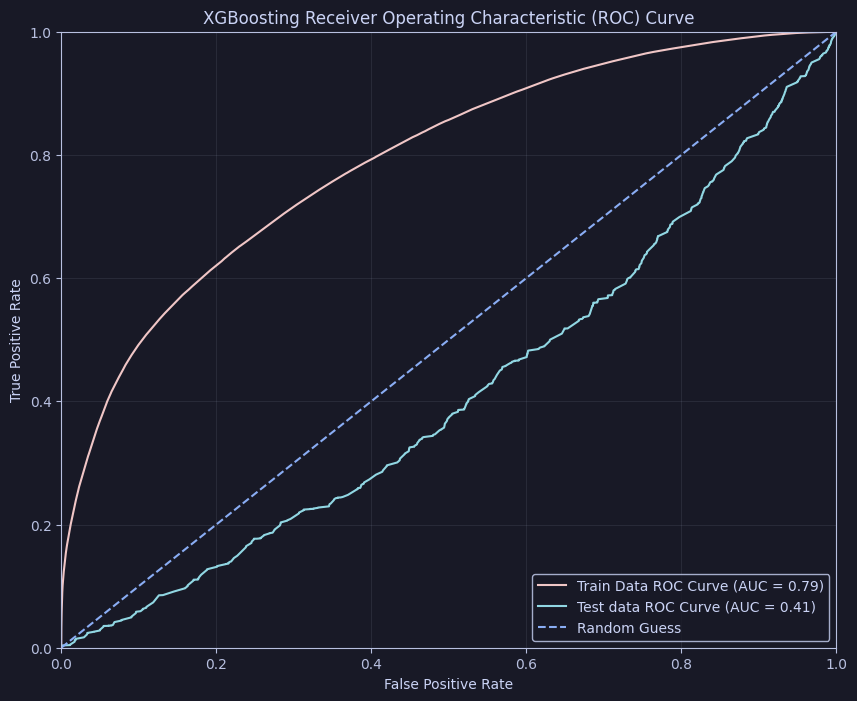

In [25]:
# Setting up the plot
plt.figure(figsize=(10, 8), facecolor=background_color)
ax = plt.gca()  # Get the current Axes
ax.set_facecolor(background_color)  # Set the background color of the Axes

# Customize axis colors
ax.tick_params(axis='x', colors=axis_colour)  # Set x-axis tick color
ax.tick_params(axis='y', colors=axis_colour)  # Set y-axis tick color
ax.spines['bottom'].set_color(axis_colour)  # Set bottom spine color
ax.spines['left'].set_color(axis_colour)    # Set left spine color
ax.spines['top'].set_color(axis_colour)  # Set bottom spine color
ax.spines['right'].set_color(axis_colour)    # Set left spine color

# Plotting

# Plot the ROC curve
plt.plot(fpr_train, tpr_train, color=roc_train_colour, label=f'Train Data ROC Curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color=roc_test_colour, label=f'Test data ROC Curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color=guess_colour, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate', color=text_colour)  # White text for better contrast
plt.ylabel('True Positive Rate', color=text_colour)  # White text for better contrast
plt.title('XGBoosting Receiver Operating Characteristic (ROC) Curve', color=text_colour)
plt.legend(loc='lower right', facecolor=background_color, edgecolor=text_colour, labelcolor=text_colour)
plt.grid(alpha=0.1, color=axis_colour)  # Adjust grid line color for visibility

# Set the x and y limits to start at 0
plt.xlim(0, 1)  # x-axis starts at 0
plt.ylim(0, 1)  # y-axis starts at 0
plt.savefig('results/XGBoost_ROC_simplified.png')
plt.show()